In [ ]:
## Authors: Raja Batra And Eli Rejto
## October 19, 2023

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Part 1: Basic System with fixed-length inputs

### Convert text to lowercase and remove all punctuation except “.” so the data only contains alphabet characters, whitespace, and periods

In [ ]:
def englishsplitintosentences(text):
    sentences = re.split(r'=', text)
    return sentences

def spanishsplitintosentences(text):
    sentences = re.findall(r'\*(.*?)\#', text)
    return sentences

def preprocesssentence(sentence):
    sentence = sentence.lower()  # Convert to lowercase
    sentence = ''.join(char if char.isalpha() or char.isspace() or char == '.' else ' ' for char in sentence)  # Remove punctuation
    return sentence

In [ ]:
# Apply preprocessing to all English sentences
english_file_path = '/content/drive/MyDrive/dataforbuildingmodel/someenglishtext'
with open(english_file_path, 'r', encoding='latin-1') as file:
    english_text = file.read()

english_sentences = englishsplitintosentences(english_text)


english_sentences = [preprocesssentence(sentence) for sentence in english_sentences]


In [ ]:
print(english_sentences[0:3])

[' \n ', ' valkyria chronicles iii ', ' \n \n senjå  no valkyria      unk  chronicles   japanese   æ  å\xa0 ã  ã  ã  ã  ã  ã  ã ªã      lit . valkyria of the battlefield       commonly referred to as valkyria chronicles iii outside japan   is a tactical role     playing video game developed by sega and media.vision for the playstation portable . released in january      in japan   it is the third game in the valkyria series . employing the same fusion of tactical and real     time gameplay as its predecessors   the story runs parallel to the first game and follows the   nameless     a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit    unk  raven   . \n the game began development in        carrying over a large portion of the work done on valkyria chronicles ii . while it retained the standard features of the series   it also underwent multiple adjustments   such as making the gam

In [ ]:
# Apply preprocessing to all Spanish sentences
spanish_file_path = '/content/drive/MyDrive/dataforbuildingmodel/somespanishtext'
with open(spanish_file_path, 'r', encoding='latin-1') as file:
    spanish_text = file.read()
spanish_sentences = spanishsplitintosentences(spanish_text)


spanish_sentences = [preprocesssentence(sentence) for sentence in spanish_sentences]



In [ ]:
processedspanishtext = ' '.join(spanish_sentences)

processedenglishtext = ' '.join(english_sentences)

### Determine a set of unique characters and map all characters to integers

In [ ]:
unique_chars = sorted(set(processedenglishtext + processedspanishtext))

In [ ]:
print(unique_chars)

['\n', ' ', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ª', 'µ', 'á', 'â', 'ã', 'å', 'æ', 'î', 'ï']


### map characters to integers

In [ ]:
chardict = {char: idx for idx, char in enumerate(unique_chars)}


def texttoint(text, chardict):
    mappedtext = []
    for char in text:
        mappedtext.append(chardict[char])
    return mappedtext

mappedspanishtext = texttoint(processedspanishtext, chardict)
mappedspanishlabels = [1] * len(mappedspanishtext)
mappedenglishtext = texttoint(processedenglishtext, chardict)

mappedenlishlabels = [0] * len(mappedenglishtext)


In [ ]:
print(mappedenglishtext[0:100])
print(mappedenglishtext[100:200])

[1, 0, 1, 1, 1, 24, 3, 14, 13, 27, 20, 11, 3, 1, 5, 10, 20, 17, 16, 11, 5, 14, 7, 21, 1, 11, 11, 11, 1, 1, 1, 0, 1, 0, 1, 21, 7, 16, 12, 35, 1, 1, 16, 17, 1, 24, 3, 14, 13, 27, 20, 11, 3, 1, 1, 1, 1, 1, 1, 23, 16, 13, 1, 1, 5, 10, 20, 17, 16, 11, 5, 14, 7, 21, 1, 1, 1, 12, 3, 18, 3, 16, 7, 21, 7, 1, 1, 1, 36, 1, 1, 35, 29, 1, 34, 1, 1, 34, 1, 1]
[34, 1, 1, 34, 1, 1, 34, 1, 1, 34, 1, 1, 34, 1, 30, 34, 1, 1, 1, 1, 1, 1, 14, 11, 22, 1, 2, 1, 24, 3, 14, 13, 27, 20, 11, 3, 1, 17, 8, 1, 22, 10, 7, 1, 4, 3, 22, 22, 14, 7, 8, 11, 7, 14, 6, 1, 1, 1, 1, 1, 1, 1, 5, 17, 15, 15, 17, 16, 14, 27, 1, 20, 7, 8, 7, 20, 20, 7, 6, 1, 22, 17, 1, 3, 21, 1, 24, 3, 14, 13, 27, 20, 11, 3, 1, 5, 10, 20, 17, 16]


### splitting into training and validation data and making chunks within data

In [ ]:
chunk_length = 100
trainenglishchunk = [mappedenglishtext[i:i+chunk_length] for i in range(0, len(mappedenglishtext), chunk_length)]
trainingenglishlabels = [0] * len(trainenglishchunk)
trainspanishchunk = [mappedspanishtext[i:i+chunk_length] for i in range(0, len(mappedspanishtext), chunk_length)]
trainingspanishlabels = [1] * len(trainspanishchunk)



In [ ]:
df1 = pd.DataFrame({'chunk': trainenglishchunk, 'language': 0})

df2 = pd.DataFrame({'chunk': trainspanishchunk, 'language': 1})

# Concatenate the two DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)



##drops chunk if it is not 100
combined_df['chunk'] = combined_df['chunk'].apply(lambda x: x if len(x) == chunk_length else None)
combined_df = combined_df.dropna().reset_index(drop=True)


#Split Training and Validation Data
Training_Fraction = 0.8

validation_split = 0.2

# Split the DataFrame into training and validation sets
training_df, valid_df = train_test_split(combined_df, test_size=validation_split)
print(training_df.head())

batch_size = 32


                                                  chunk  language
852   [1, 22, 17, 1, 14, 7, 3, 18, 8, 20, 17, 9, 1, ...         0
368   [7, 16, 5, 7, 1, 22, 17, 1, 17, 20, 6, 7, 20, ...         0
21    [11, 5, 1, 4, 17, 17, 13, 1, 1, 1, 1, 1, 14, 1...         0
1979  [11, 14, 6, 11, 16, 9, 1, 2, 1, 5, 17, 15, 15,...         0
3668  [1, 26, 11, 11, 11, 14, 23, 11, 21, 1, 26, 11,...         1


In [ ]:
print(df2.head())
print(combined_df.iloc[0])

                                               chunk  language
0  [14, 3, 1, 7, 16, 5, 11, 5, 14, 17, 18, 7, 6, ...         1
1  [23, 16, 1, 27, 1, 5, 17, 8, 23, 16, 6, 3, 6, ...         1
2  [21, 18, 7, 20, 3, 16, 22, 17, 1, 19, 23, 7, 1...         1
3  [17, 5, 11, 6, 17, 21, 1, 14, 11, 4, 20, 17, 2...         1
4  [28, 11, 14, 38, 1, 1, 9, 27, 11, 1, 7, 14, 1,...         1
chunk       [1, 0, 1, 1, 1, 24, 3, 14, 13, 27, 20, 11, 3, ...
language                                                    0
Name: 0, dtype: object


In [ ]:
# convert training data into PyTorch tensors
X = torch.tensor(training_df['chunk'], dtype=torch.int64)
y = torch.tensor(training_df['language'], dtype=torch.int64).reshape(-1, 1)

# create DataLoader, then take one batch
trainloader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=2)



In [ ]:
# convert validation data into PyTorch tensors
Xval = torch.tensor(training_df['chunk'], dtype=torch.int64)
yval = torch.tensor(training_df['language'], dtype=torch.int64).reshape(-1, 1)

# create DataLoader, then take one batch
valloader = DataLoader(list(zip(Xval,yval)), shuffle=True, batch_size=2)

In [ ]:
#train_loader = DataLoader(training_df, batch_size=batch_size, shuffle=True)
#valid_loader = DataLoader(valid_df, batch_size=batch_size, shuffle=False)

## Train 1 Layer Model

In [ ]:
#loosely based on https://www.kaggle.com/code/mehmetlaudatekman/lstm-text-classification-pytorch
class LanguageClassificationModel(nn.Module):
    def __init__(self, input_size, embeddingdim, hidden_size, num_classes):
        super(LanguageClassificationModel, self).__init__()
        self.embedding = nn.Embedding(input_size, embeddingdim)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        #x: (batch_size, sequence_length)
        # 2x 100
        embedded = self.embedding(x)
        #output batch-size x seq_length x embedding_dimension
        #2 x 100 x 50
        lstm_out, _ = self.lstm(embedded)
        #Output: seq_length x batch_size x hidden_size
        #last_hidden_state: batch_size, hidden_size
        # 100 x 2 x 32 ,
        output = self.linear(lstm_out[:,-1,:])
        return output

In [ ]:
# hyperparameters for parameter
input_size = len(chardict)
hidden_size = 20
num_classes = 2  # English and Spanish
learning_rate = 0.001
embedding_dim = 25
num_epochs = 10




In [ ]:
#Lets print a representation of our model to see what we have initialized it to
print(model)

LanguageClassificationModel(
  (embedding): Embedding(39, 25)
  (lstm): LSTM(39, 20, batch_first=True)
  (linear): Linear(in_features=20, out_features=2, bias=True)
)


In [193]:
def train_model(num_epochs,learning_rate,trainloader,valloader,hidden_size):
    model = LanguageClassificationModel(input_size, embedding_dim, hidden_size, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        for batch_x, batch_y in trainloader:
            optimizer.zero_grad()

            outputs = model(batch_x)
            #print(outputs)
            batch_y = batch_y.view(-1)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)


        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in valloader:

                outputs = model(batch_x)
                batch_y = batch_y.view(-1)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        val_loss /= len(valloader)
        val_losses.append(val_loss)
        val_accuracy = 100*correct/total
        val_accuracies.append(val_accuracy)

        # Print the training and validation metrics for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f} - '
              f'Validation Loss: {val_loss:.4f} - '
              f'Validation Accuracy: {val_accuracy:.2f}%')
    print('Finished Training')
    return (train_losses, val_losses,val_accuracies)







In [192]:
def plot_losses(losses):
    train_losses,val_losses,val_accuracies = losses
    epochs = range(1, len(train_losses) + 1)

    # Plot the training loss curve
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-', color='b')

    # Plot the validation loss curve
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='-', color='r')

    # Label the axes and add a legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Curves')
    plt.legend()

    # Show the plot
    plt.show()

Epoch [1/25] - Train Loss: 0.4978 - Validation Loss: 0.4841 - Validation Accuracy: 80.09%
Epoch [2/25] - Train Loss: 0.4767 - Validation Loss: 0.4620 - Validation Accuracy: 80.09%
Epoch [3/25] - Train Loss: 0.4193 - Validation Loss: 0.4635 - Validation Accuracy: 80.20%
Epoch [4/25] - Train Loss: 0.3939 - Validation Loss: 0.2498 - Validation Accuracy: 90.18%
Epoch [5/25] - Train Loss: 0.3656 - Validation Loss: 0.4804 - Validation Accuracy: 80.09%
Epoch [6/25] - Train Loss: 0.4674 - Validation Loss: 0.4531 - Validation Accuracy: 80.14%
Epoch [7/25] - Train Loss: 0.4247 - Validation Loss: 0.3455 - Validation Accuracy: 83.73%
Epoch [8/25] - Train Loss: 0.2109 - Validation Loss: 0.1741 - Validation Accuracy: 94.55%
Epoch [9/25] - Train Loss: 0.3310 - Validation Loss: 0.4758 - Validation Accuracy: 80.09%
Epoch [10/25] - Train Loss: 0.3190 - Validation Loss: 0.1603 - Validation Accuracy: 95.22%
Epoch [11/25] - Train Loss: 0.1479 - Validation Loss: 0.1173 - Validation Accuracy: 96.72%
Epoch [1

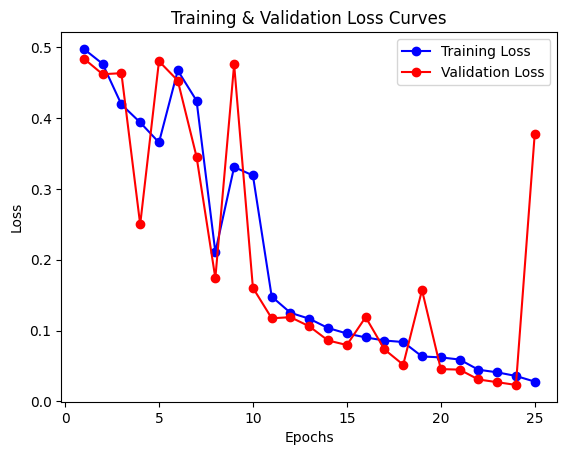

In [ ]:
#Experiment 1 average epochs, lr and hiddensize
num_epochs = 25
lr = 0.01
hiddensize = 10


losses = train_model(num_epochs,lr,trainloader,valloader,hiddensize)
plot_losses(losses)

Epoch [1/50] - Train Loss: 0.5059 - Validation Loss: 0.4856 - Validation Accuracy: 80.09%
Epoch [2/50] - Train Loss: 0.4827 - Validation Loss: 0.4770 - Validation Accuracy: 80.09%
Epoch [3/50] - Train Loss: 0.4731 - Validation Loss: 0.4607 - Validation Accuracy: 80.09%
Epoch [4/50] - Train Loss: 0.4468 - Validation Loss: 0.4720 - Validation Accuracy: 80.09%
Epoch [5/50] - Train Loss: 0.4579 - Validation Loss: 0.4317 - Validation Accuracy: 80.12%
Epoch [6/50] - Train Loss: 0.4155 - Validation Loss: 0.4524 - Validation Accuracy: 80.39%
Epoch [7/50] - Train Loss: 0.4134 - Validation Loss: 0.2300 - Validation Accuracy: 90.63%
Epoch [8/50] - Train Loss: 0.3684 - Validation Loss: 0.4547 - Validation Accuracy: 80.14%
Epoch [9/50] - Train Loss: 0.3450 - Validation Loss: 0.1333 - Validation Accuracy: 97.02%
Epoch [10/50] - Train Loss: 0.0907 - Validation Loss: 0.0412 - Validation Accuracy: 99.30%
Epoch [11/50] - Train Loss: 0.0520 - Validation Loss: 0.0270 - Validation Accuracy: 99.47%
Epoch [1

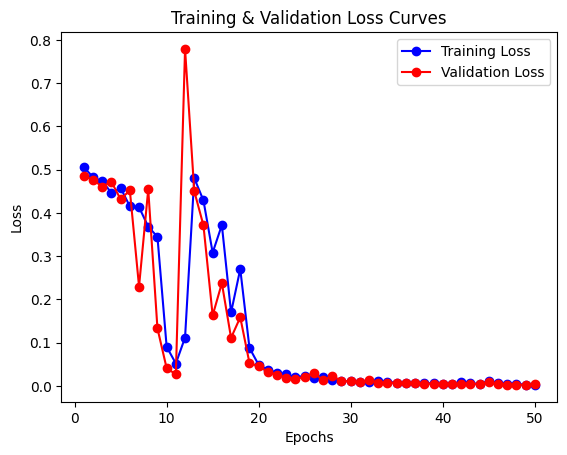

In [ ]:
#Experiment 2 High epochs, average lr and hiddensize
num_epochs = 50
lr = 0.01
hiddensize = 10


losses = train_model(num_epochs,lr,trainloader,valloader,hiddensize)
plot_losses(losses)

Epoch [1/50] - Train Loss: 0.5153 - Validation Loss: 0.4897 - Validation Accuracy: 80.09%
Epoch [2/50] - Train Loss: 0.4839 - Validation Loss: 0.4770 - Validation Accuracy: 80.09%
Epoch [3/50] - Train Loss: 0.4712 - Validation Loss: 0.4622 - Validation Accuracy: 80.09%
Epoch [4/50] - Train Loss: 0.4535 - Validation Loss: 0.4371 - Validation Accuracy: 80.09%
Epoch [5/50] - Train Loss: 0.4232 - Validation Loss: 0.4927 - Validation Accuracy: 80.09%
Epoch [6/50] - Train Loss: 0.4622 - Validation Loss: 0.4452 - Validation Accuracy: 80.09%
Epoch [7/50] - Train Loss: 0.4381 - Validation Loss: 0.4826 - Validation Accuracy: 80.09%
Epoch [8/50] - Train Loss: 0.4749 - Validation Loss: 0.4667 - Validation Accuracy: 80.09%
Epoch [9/50] - Train Loss: 0.4604 - Validation Loss: 0.4511 - Validation Accuracy: 80.12%
Epoch [10/50] - Train Loss: 0.4419 - Validation Loss: 0.4228 - Validation Accuracy: 80.14%
Epoch [11/50] - Train Loss: 0.3592 - Validation Loss: 0.1962 - Validation Accuracy: 93.80%
Epoch [1

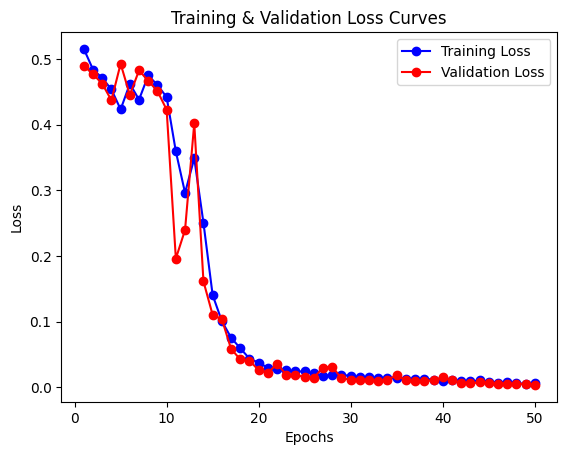

In [ ]:
#Experiment 3 high epochs, lower lr and higher hiddensize
num_epochs = 50
lr = 0.005
hiddensize = 25


losses = train_model(num_epochs,lr,trainloader,valloader,hiddensize)
plot_losses(losses)

We see that decreasing the learning rate reduces the amount of spikes and bouncing around of the gradient. Increasing the hidden layers does not have a super noticeable effect on the loss. Adding epochs allows the loss to reach a better steady state.

### Intuition Portion

## Part 2: Realistic system with variable-length inputs

### break data into sentences

In [175]:
def englishsplitintosentences(text):
    sentences = re.split(r'=', text)
    sentence_pattern = r'[.!=] +'


    sentences = re.split(sentence_pattern, text)
    return sentences

def spanishsplitintosentences(text):
    sentences = re.findall(r'\*(.*?)\#', text)
    return sentences

def preprocesssentence(sentence):
    sentence = sentence.lower()  # Convert to lowercase
    sentence = ''.join(char if char.isalpha() or char.isspace() or char == '.' else ' ' for char in sentence)

    return sentence

In [176]:
english_sentences2 = englishsplitintosentences(english_text)


english_sentences2 = [preprocesssentence(sentence) for sentence in english_sentences2]

In [177]:
spanish_sentences2 = spanishsplitintosentences(spanish_text)


spanish_sentences2 = [preprocesssentence(sentence) for sentence in spanish_sentences2]

In [178]:
print(english_sentences2[10])

the game  s opening theme was sung by may  n 


In [179]:
print(spanish_sentences2[2])

es uno de los mï  s conocidos libros en espaï  ol que tratan sobre el tema junto con curso prï  ctico de esperanto ferenc szilï  gyi


In [180]:
unique_chars2 = sorted(set(spanish_sentences2 + english_sentences))

In [181]:
chardict2 = {char: idx for idx, char in enumerate(unique_chars)}


def texttoint(text, chardict):
    mappedtext = []
    for char in text:
        mappedtext.append(chardict[char])
    return mappedtext

In [182]:
mappedenglishsentence2 = []
mappedspanishsentence2 = []

for sentence in english_sentences2:

    mappedenglishsentence2.append(texttoint(sentence, chardict2))

for sentence in spanish_sentences2:
    mappedspanishsentence2.append(texttoint(sentence, chardict2))



In [183]:
print(mappedenglishsentence2[10])

[22, 10, 7, 1, 9, 3, 15, 7, 1, 1, 21, 1, 17, 18, 7, 16, 11, 16, 9, 1, 22, 10, 7, 15, 7, 1, 25, 3, 21, 1, 21, 23, 16, 9, 1, 4, 27, 1, 15, 3, 27, 1, 1, 16, 1]


#### I find the longest sentence and zero pad all the other sentences so they are the same length

In [184]:
max_length = max(len(sentence) for sentence in mappedenglishsentence2)
## I set the max length of a sentence to be 500 as this will cover the vast majority of sentences. I will then
max_length = 500
paddedenglish = []

for int_list in mappedenglishsentence2:
    if len(int_list) < max_length:
        padded_list = int_list + [0] * (max_length - len(int_list))
        paddedenglish.append(padded_list)
    else:
        truncated_list = int_list[:max_length]
        paddedenglish.append(truncated_list)

paddedspanish = []

for int_list in mappedspanishsentence2:
    if len(int_list) < max_length:
        padded_list = int_list + [0] * (max_length - len(int_list))
        paddedspanish.append(padded_list)
    else:
        truncated_list = int_list[:max_length]
        paddedspanish.append(truncated_list)

In [185]:
print(paddedspanish[2])

[7, 21, 1, 23, 16, 17, 1, 6, 7, 1, 14, 17, 21, 1, 15, 38, 1, 1, 21, 1, 5, 17, 16, 17, 5, 11, 6, 17, 21, 1, 14, 11, 4, 20, 17, 21, 1, 7, 16, 1, 7, 21, 18, 3, 38, 1, 1, 17, 14, 1, 19, 23, 7, 1, 22, 20, 3, 22, 3, 16, 1, 21, 17, 4, 20, 7, 1, 7, 14, 1, 22, 7, 15, 3, 1, 12, 23, 16, 22, 17, 1, 5, 17, 16, 1, 5, 23, 20, 21, 17, 1, 18, 20, 38, 1, 1, 5, 22, 11, 5, 17, 1, 6, 7, 1, 7, 21, 18, 7, 20, 3, 16, 22, 17, 1, 8, 7, 20, 7, 16, 5, 1, 21, 28, 11, 14, 38, 1, 1, 9, 27, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Train model with 0 padded inputs

In [186]:
df3 = pd.DataFrame({'chunk': paddedenglish, 'language': 0})

df4 = pd.DataFrame({'chunk': paddedspanish, 'language': 1})

# Concatenate the two DataFrames
combined_df2 = pd.concat([df3, df4], ignore_index=True)

In [188]:
#Split Training and Validation Data
Training_Fraction = 0.8

validation_split = 0.2

# Split the DataFrame into training and validation sets
training_df2, valid_df2 = train_test_split(combined_df2, test_size=validation_split)
print(training_df2.head())

batch_size = 32

                                                  chunk  language
4505  [14, 3, 1, 5, 10, 11, 5, 3, 1, 6, 11, 5, 7, 1,...         1
4261  [6, 7, 1, 6, 11, 5, 11, 7, 15, 4, 20, 7, 1, 15...         1
2197  [18, 17, 14, 11, 21, 10, 1, 6, 7, 3, 22, 10, 1...         0
2336  [3, 1, 21, 23, 20, 24, 7, 27, 1, 17, 8, 1, 18,...         0
588   [0, 1, 0, 1, 11, 16, 1, 1, 1, 1, 1, 1, 1, 1, 8...         0


In [189]:
# convert training data into PyTorch tensors
X2 = torch.tensor(training_df['chunk'], dtype=torch.int64)
y2 = torch.tensor(training_df['language'], dtype=torch.int64).reshape(-1, 1)

# create DataLoader, then take one batch
trainloader2 = DataLoader(list(zip(X2,y2)), shuffle=True, batch_size=2)

In [190]:
# convert validation data into PyTorch tensors
Xval2 = torch.tensor(training_df['chunk'], dtype=torch.int64)
yval2 = torch.tensor(training_df['language'], dtype=torch.int64).reshape(-1, 1)

# create DataLoader, then take one batch
valloader2 = DataLoader(list(zip(Xval2,yval2)), shuffle=True, batch_size=2)

Epoch [1/20] - Train Loss: 0.4970 - Validation Loss: 0.4855 - Validation Accuracy: 80.23%
Epoch [2/20] - Train Loss: 0.4809 - Validation Loss: 0.4761 - Validation Accuracy: 80.23%
Epoch [3/20] - Train Loss: 0.4724 - Validation Loss: 0.4668 - Validation Accuracy: 80.23%
Epoch [4/20] - Train Loss: 0.4602 - Validation Loss: 0.4493 - Validation Accuracy: 80.28%
Epoch [5/20] - Train Loss: 0.4201 - Validation Loss: 0.6295 - Validation Accuracy: 69.61%
Epoch [6/20] - Train Loss: 0.4379 - Validation Loss: 0.4309 - Validation Accuracy: 80.31%
Epoch [7/20] - Train Loss: 0.3480 - Validation Loss: 0.2385 - Validation Accuracy: 90.68%
Epoch [8/20] - Train Loss: 0.4500 - Validation Loss: 0.4533 - Validation Accuracy: 80.26%
Epoch [9/20] - Train Loss: 0.4376 - Validation Loss: 0.4443 - Validation Accuracy: 80.28%
Epoch [10/20] - Train Loss: 0.4224 - Validation Loss: 0.3745 - Validation Accuracy: 81.84%
Epoch [11/20] - Train Loss: 0.2430 - Validation Loss: 0.1004 - Validation Accuracy: 97.58%
Epoch [1

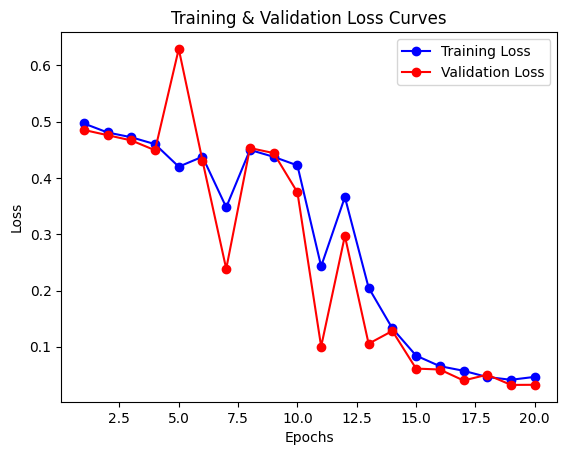

In [194]:
#Sentences of any length
num_epochs = 20
lr = 0.005
hiddensize = 25

#Set trainloader + valloader


losses = train_model(num_epochs,lr,trainloader2,valloader2,hiddensize)
plot_losses(losses)

I noticed that with using set sentences rather than chunks, the training is able to reach a higher accuracy at a faster rate. However, the difference did not seem to be significantly higher. This likely shows that the model is able to determine a language mostly based on the words rather than the structure of a sentence.